In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/community/vertex_endpoints/tf_hub_obj_detection/deploy_tfhub_object_detection_on_vertex_endpoints.ipynb"">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/community/vertex_endpoints/tf_hub_obj_detection/deploy_tfhub_object_detection_on_vertex_endpoints.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/community/vertex_endpoints/tf_hub_obj_detection/deploy_tfhub_object_detection_on_vertex_endpoints.ipynb"
      <img src="https://cloud.google.com/images/products/ai/ai-solutions-icon.svg" alt="Vertex AI Workbench notebook"> Open in Vertex AI Workbench
    </a>
  </td> 
</table>

# Deploying a TensorFlow Hub object detection model using Vertex AI Endpoints

## Overview
This tutorial demonstrates how to take a TensorFlow Hub object detection model, add a preprocessing layer and deploy it to a Vertex AI endpoint for online prediction.

Because the object detection model accepts tensors as an input, we will add a preprocessing layer that accepts jpeg strings and decodes them. This makes it easier for clients to call the endpoint without having to implement their own TensorFlow logic.

## Model
The model used for this tutorial is the `CenterNet HourGlass104 Keypoints 512x512` from [TensorFlow Hub open source model repository](https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1)

## Objective

The steps performed include:
- Download a object detection model from TensorFlow Hub.
- Create a preprocessing layer using @tf.function.
- Upload the model to Vertex AI `Models`.
- Create a Vertex AI `Endpoint`.
- Call the endpoint with both the `Python Vertex AI SDK` and through command line using `CURL`.
- Undeploy the endpoint and delete the model.


## Costs
This tutorial uses billable components of Google Cloud:
- Vertex AI
- Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Installation
Install the latest version of Vertex SDK for Python

In [ ]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [ ]:
! pip install {USER_FLAG} --upgrade google-cloud-aiplatform

Install TensorFlow.

In [ ]:
!pip install -U "tensorflow>=2.8"

### Restart the kernel

Once you've installed everything, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

4. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

5. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you might be able to get your project ID using `gcloud`.

In [ ]:
import os

PROJECT_ID = ""

if not os.getenv("IS_TESTING"):
    # Get your Google Cloud project ID from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Otherwise, set your project ID here.

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = ""  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Google Cloud Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

You first upload the model files to a Cloud Storage bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [ ]:
BUCKET_NAME = ""  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

In [ ]:
print(BUCKET_NAME)

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -p $PROJECT_ID -l $REGION $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

## Download and extract the model
There are various object detection models in TensorFlow Hub. We will be using the `CenterNet HourGlass104 Keypoints 512x512`.

In [ ]:
# Download and extract model
!wget https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1?tf-hub-format=compressed
!tar xvzf 1?tf-hub-format=compressed
!mkdir obj_detect_model
!mv ./saved_model.pb obj_detect_model/
!mv ./variables obj_detect_model/

## Visualization tools
To visualize the images with the proper detected boxes, keypoints and segmentation, we will use the TensorFlow Object Detection API. To install it we will clone the repo.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from six import BytesIO

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Installing the object detection API

In [ ]:
%%bash

sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
pip install .

Now we can import the dependencies we will need later

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

## Load label map data (for plotting).
Label maps correspond index numbers to category names, so that when our convolution network predicts 5, we know that this corresponds to airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [ ]:
PATH_TO_LABELS = "./models/research/object_detection/data/mscoco_label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS, use_display_name=True
)
print(category_index[5])

## Load the model
Here we will load the downloaded model into memory.

In [ ]:
model = tf.saved_model.load("obj_detect_model/")

Load an image and use the model for inference.

In [ ]:
image_path = "models/research/object_detection/test_images/image2.jpg"


def load_image_into_numpy_array(path):
    image_data = tf.io.gfile.GFile(path, "rb").read()
    image = Image.open(BytesIO(image_data))

    (width, height) = image.size
    return np.array(image.getdata()).reshape((1, height, width, 3)).astype(np.uint8)


image_np = load_image_into_numpy_array(image_path)
plt.figure(figsize=(24, 32))
plt.imshow(image_np[0])
plt.show()


results = model(image_np)
result = {key: value.numpy() for key, value in results.items()}

Visualize results

In [ ]:
COCO17_HUMAN_POSE_KEYPOINTS = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (0, 5),
    (0, 6),
    (5, 7),
    (7, 9),
    (6, 8),
    (8, 10),
    (5, 6),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16),
]

label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if "detection_keypoints" in result:
    keypoints = result["detection_keypoints"][0]
    keypoint_scores = result["detection_keypoint_scores"][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections[0],
    result["detection_boxes"][0],
    (result["detection_classes"][0] + label_id_offset).astype(int),
    result["detection_scores"][0],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=0.30,
    agnostic_mode=False,
    keypoints=keypoints,
    keypoint_scores=keypoint_scores,
    keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS,
)

plt.figure(figsize=(24, 32))
plt.imshow(image_np_with_detections[0])
plt.show()

## Create a preprocessing function for Vertex AI serving.
The model expects a numpy array as an input. This creates two problems for our endpoint:
* Vertex AI public endpoints have a maximum request size of 1.5 MB. Images are much larger than this.
* It would make it more difficult for clients based in languages other than Python to build a request.

These two limitations can be solved by building a preprocessing function and attaching it to our model.

We will create a preprocessing function that takes a jpeg encoded image, resizes it to the model's minimum required input and passes this preprocessed input to the model. We will then save the model with the preprocessing function which will be ready to be uploaded to our Vertex AI endpoint.

The image will be passed to our endpoint as a base64 encoded jpeg string.

In [ ]:
VERTEX_MODEL_PATH = "obj_detect_model_vertex/"


def _preprocess(bytes_inputs):
    decoded = tf.io.decode_jpeg(bytes_inputs, channels=3)
    resized = tf.image.resize(decoded, size=(512, 512))
    return tf.cast(resized, dtype=tf.uint8)


def _get_serve_image_fn(model):
    @tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
    def serve_image_fn(bytes_inputs):
        decoded_images = tf.map_fn(_preprocess, bytes_inputs, dtype=tf.uint8)
        return model(decoded_images)

    return serve_image_fn


signatures = {
    "serving_default": _get_serve_image_fn(model).get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string)
    )
}

tf.saved_model.save(model, VERTEX_MODEL_PATH, signatures=signatures)

We will verify that the input was modified correctly by using the `saved_model_cli` command on both the original and vertexai prepared model.

The results for the `serving_default` signature should be as follows.


Original model:

```
signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_tensor'] tensor_info:
        dtype: DT_UINT8
        shape: (1, -1, -1, 3)
        name: serving_default_input_tensor:0
```

Vertex AI model:

```
signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['bytes_inputs'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_bytes_inputs:0
```

In [ ]:
!saved_model_cli show --dir obj_detect_model --all

In [ ]:
!saved_model_cli show --dir obj_detect_model_vertex --all

Lets test the preprocessing function by passing it a base 64 encoded jpeg image.

In [ ]:
vertex_model = tf.saved_model.load(VERTEX_MODEL_PATH)

In [ ]:
import base64


def encode_image(image):
    with open(image, "rb") as image_file:
        encoded_string = base64.urlsafe_b64encode(image_file.read()).decode("utf-8")
    return encoded_string


results = vertex_model([_preprocess(tf.io.decode_base64(encode_image(image_path)))])

View the results

In [ ]:
# different object detection models have additional results
# all of them are explained in the documentation
result = {key: value.numpy() for key, value in results.items()}

label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if "detection_keypoints" in result:
    keypoints = result["detection_keypoints"][0]
    keypoint_scores = result["detection_keypoint_scores"][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections[0],
    result["detection_boxes"][0],
    (result["detection_classes"][0] + label_id_offset).astype(int),
    result["detection_scores"][0],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=0.30,
    agnostic_mode=False,
    keypoints=keypoints,
    keypoint_scores=keypoint_scores,
    keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS,
)

plt.figure(figsize=(24, 32))
plt.imshow(image_np_with_detections[0])
plt.show()

## Create a Vertex AI endpoint
In this section we will upload the model to Google Cloud Storage and reference it inside Vertex AI for endpoints deployment

In [ ]:
!gsutil cp -r $VERTEX_MODEL_PATH $BUCKET_NAME/obj_detection_model_vertex

In [ ]:
!gsutil ls $BUCKET_NAME

Create a model in Vertex AI

In [ ]:
!gcloud ai models upload \
--region=us-central1 \
--project=$PROJECT_ID \
--display-name=object-detection \
--container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-5:latest \
--artifact-uri=$BUCKET_NAME/obj_detection_model_vertex

To deploy to the endpoint, grab the model ID from the Google Cloud console >> Vertex AI >> Models.

This will be used to deploy the model.

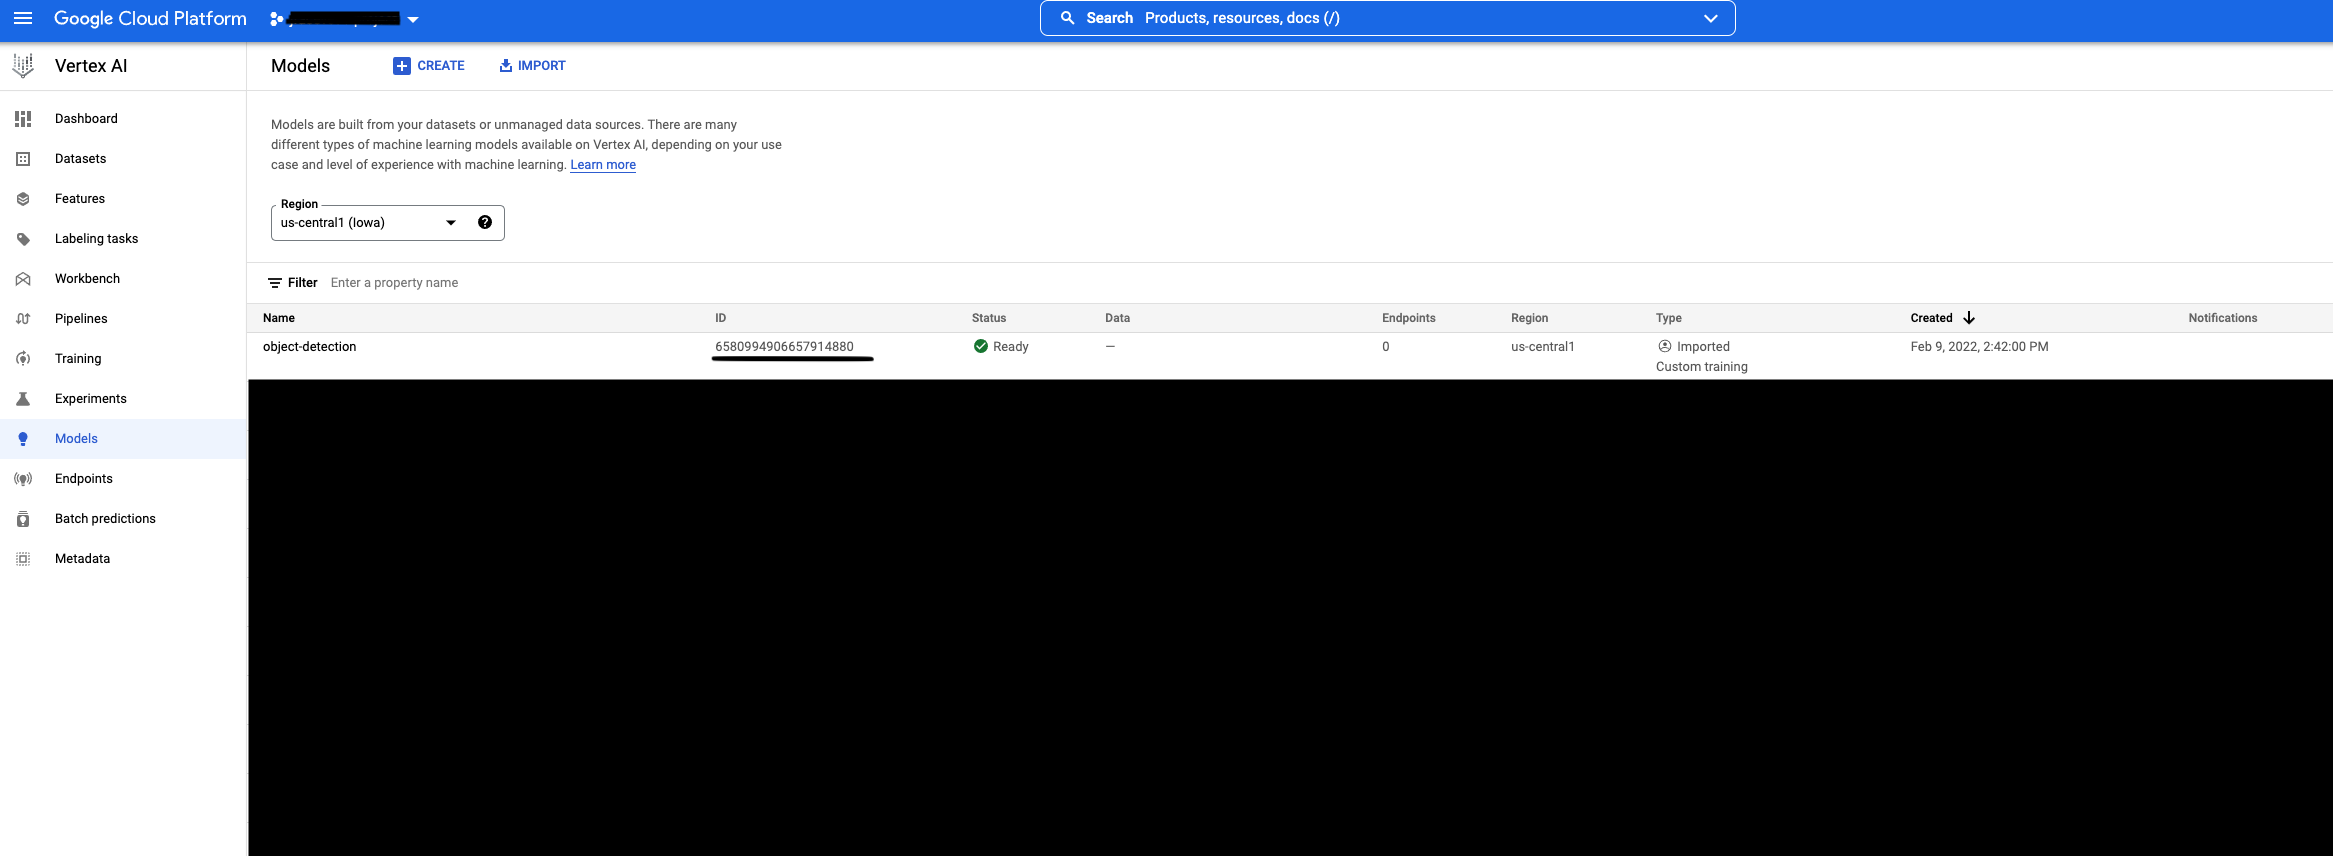

Create endpoint

In [ ]:
!gcloud ai endpoints create \
--project=$PROJECT_ID \
--region=$REGION \
--display-name=object-detection-endpoint

Retrieve the endpoint ID

In [ ]:
!gcloud ai endpoints list \
--project=$PROJECT_ID \
--region=$REGION \
--filter=display_name=object-detection-endpoint

**Don't forget to change the endpoint and model Ids.**

In [ ]:
ENDPOINT_ID = "" # @param {type:"string"}
MODEL_ID = "" # @param {type:"string"}
!gcloud ai endpoints deploy-model $ENDPOINT_ID \
--project=$PROJECT_ID \
--region=$REGION \
--model=$MODEL_ID \
--display-name=object-detection-endpoint \
--traffic-split=0=100

Write the request to a json file and call the endpoint using Curl.

First we need to reduce our image memory footprint. As of Feb. 2022, Vertex AI endpoints has a maximum request size of 1.5mb. This is done to keep the containers behind endpoints from crashing during heavy load times.

In [ ]:
import os

print(os.stat(image_path).st_size)

im = Image.open(image_path)
im.save("image2.jpg", quality=95)
print(os.stat("image2.jpg").st_size)

In [ ]:
!echo {"\""instances"\"" : [{"\""bytes_inputs"\"" : {"\""b64"\"" : "\""$(base64 "image2.jpg")"\""}}]} > instances.json

In [ ]:
!curl POST  \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
https://us-central1-aiplatform.googleapis.com/v1/projects/$PROJECT_ID/locations/us-central1/endpoints/$ENDPOINT_ID:predict \
-d @instances.json > results.json

## Make Predictions using the Vertex SDK
The Vertex SDK has convenient methods to call endpoints to make predictions.
First, we get the serving input from the model. This is what the endpoint expects as a key for the base64 encoded image.

In [ ]:
# Get the input key
serving_input = list(
    vertex_model.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving input :", serving_input)

Load an endpoint object.

In [ ]:
from google.cloud import aiplatform

aip_endpoint_name = (
    f"projects/{PROJECT_ID}/locations/us-central1/endpoints/{ENDPOINT_ID}"
)
endpoint = aiplatform.Endpoint(aip_endpoint_name)

In [ ]:
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


# Endpoints will do the base64 decoding, so we change the function to encode the image a bit.
def encode_image_bytes(image_path):
    bytes = tf.io.read_file(image_path)
    return base64.b64encode(bytes.numpy()).decode("utf-8")


instances_list = [{serving_input: {"b64": encode_image_bytes("image2.jpg")}}]
instances = [json_format.ParseDict(s, Value()) for s in instances_list]
results = endpoint.predict(instances=instances)

View results

In [ ]:
# different object detection models have additional results
# all of them are explained in the documentation
prediction_results = results.predictions[0]
result = {key: np.array([value]) for key, value in prediction_results.items()}

label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if "detection_keypoints" in result:
    keypoints = result["detection_keypoints"][0]
    keypoint_scores = result["detection_keypoint_scores"][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections[0],
    result["detection_boxes"][0],
    (result["detection_classes"][0] + label_id_offset).astype(int),
    result["detection_scores"][0],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=0.30,
    agnostic_mode=False,
    keypoints=keypoints,
    keypoint_scores=keypoint_scores,
    keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS,
)

plt.figure(figsize=(24, 32))
plt.imshow(image_np_with_detections[0])
plt.show()

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
%%bash --out ENDPOINT_MODEL_ID
ENDPOINT_MODEL_ID=$(gcloud ai endpoints describe 4308018499021701120 --region=us-central1 --project=jfacevedo-project | grep "id:")
ENDPOINT_MODEL_ID=`echo $ENDPOINT_MODEL_ID | cut -d' ' -f2`
echo $ENDPOINT_MODEL_ID | tr -d "'"

In [ ]:
# Undeploy endpoint
! gcloud ai endpoints undeploy-model $ENDPOINT_ID \
--project=$PROJECT_ID \
--region=$REGION \
--deployed-model-id=$ENDPOINT_MODEL_ID \

# Delete endpoint resource
! gcloud ai endpoints delete $ENDPOINT_ID \
--project=$PROJECT_ID \
--region=$REGION \
--quiet

# Delete model resource
! gcloud ai models delete $MODEL_ID \
--project=$PROJECT_ID \
--region=$REGION \
--quiet

# Delete Cloud Storage objects that were created
#! gsutil -m rm -r $BUCKET_NAME